The **Traveling Salesperson Problem (TSP)** is a well-known combinatorial optimization problem that seeks to determine a least cost route for a salesperson to visit a given set of cities exactly once and return to the starting point. Formally, it is defined on a weighted graph where nodes represent cities, edges represent connections between cities, and edge weights denote travel costs (such as distance or time). The objective is to minimize the total travel cost while ensuring that each city is visited once.

## Import Packages and Read Data

In [2]:
import gurobipy as gp
from gurobipy import quicksum as qsum 
from gurobipy import GRB
import pandas as pd
import util
import networkx as nx
import matplotlib.pyplot as plt
import time
import tsp_map
import itertools

## Cities

In [3]:
df_cities = pd.read_csv('cities.csv')
print(df_cities.head(10))

         City Airport Code  Latitude  Longitude  X Coordinate  Y Coordinate
0      Dallas          ADS  32.96856  -96.83644  3.131644e+06  1.136450e+06
1  Washington          WSG  40.13647  -80.29019  4.971502e+06  2.129998e+06
2      Denver          APA  39.57012 -104.84929  2.240656e+06  2.047965e+06
3      Austin          AUM  43.66264  -92.93292  3.565695e+06  2.656997e+06
4   Nashville          BNA  36.12447  -86.67818  4.261190e+06  1.562602e+06
5      Boston          BOS  42.36294  -71.00639  6.003813e+06  2.459338e+06
6   Charlotte          CLT  35.21375  -80.94906  4.898239e+06  1.437947e+06
7     Houston          CXO  30.35340  -95.41508  3.289691e+06  7.947587e+05
8     Detroit          DET  42.40933  -83.01017  4.669054e+06  2.466322e+06
9     Phoenix          DVT  33.68831 -112.08256  1.436353e+06  1.232237e+06


## Visualization

First, create the graph

In [4]:
dist_min = 0
dist_max = 5000
G = util.get_cities_graph(df_cities, dist_min, dist_max)

Next, draw the graph.

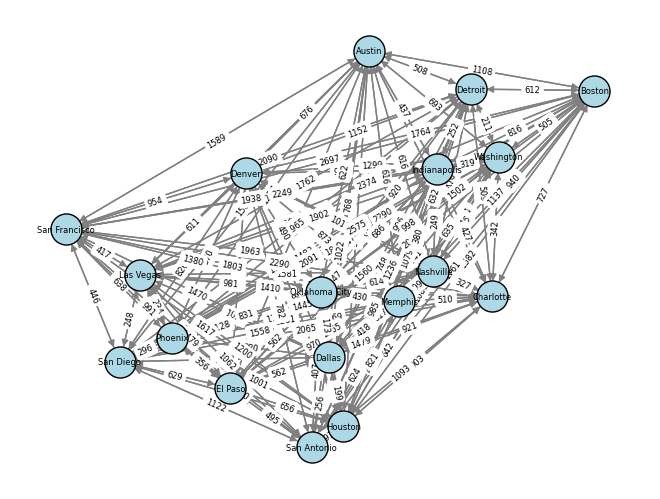

In [5]:
pos = nx.get_node_attributes(G, 'pos')
labels = nx.get_edge_attributes(G, 'weight')
formatted_labels = {k: f"{int(v)}" for k, v in labels.items()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color='gray', font_size=6, edgecolors='black')

nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_labels, 
                             font_size=6);

## Nearest Neighbor Heuristic

Implement a version of the nearest neighobr heuristic that allows the user to change the starting node.

In [6]:
def nearest_neighbor_heuristic(G : nx.DiGraph):
    visited = []
    current_node = list(G.nodes())[0]
    visited.append(current_node)
    while len(visited) < len(G.nodes()):
        neighbors = [j for j in G.neighbors(current_node) 
                     if j not in visited]
        nearest_neighbor = min(neighbors, 
            key=lambda node: G[current_node][node]['weight'])
        current_node = nearest_neighbor
        visited.append(current_node)
    visited.append(visited[0])
    return visited

## Get Solution When Starting at First Node

In [7]:
def get_cost(edges_used):
    return sum(G[u][v]['weight'] for u, v in edges_used)

In [8]:
start_time = time.time()
tour = nearest_neighbor_heuristic(G)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("Tour:", tour)
edges_used = list(zip(tour, tour[1:]))
cost = get_cost(edges_used)
formatted_cost = round(cost)
print("Cost of tour:", formatted_cost)
print("Optimization time:", execution_time, "seconds")

Tour: ['Dallas', 'Oklahoma City', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Detroit', 'Boston', 'Dallas']
Cost of tour: 8255
Optimization time: 0.0002 seconds


## Visualize Solution

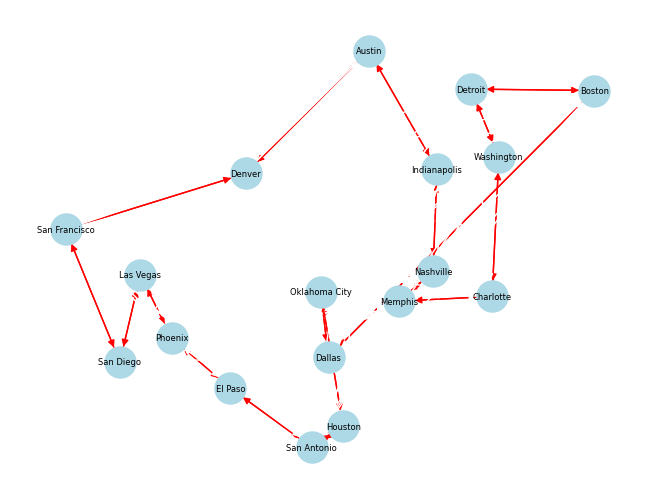

In [9]:
edge_colors = ['red' if (u, v) in edges_used or (v,u) in edges_used else 'white' 
               for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', 
        edge_color=edge_colors, font_size=6)

## Visualize Solution Using Folium

In [10]:
folium_map, cost = tsp_map.generate_html_info("Austin")
folium_map

## Local Search

In [18]:
def swap_nodes(tour, i, j):
    temp_tour = tour[:]
    temp_tour[i], temp_tour[j] = tour[j], tour[i]
    return temp_tour

def get_city_swaps_neighborhood(tour):
    ''' Returns a generator of all possible solutions in the neighborhood of the current solution '''
    temp_tour = tour[:-1]
    for i,j in itertools.combinations(range(len(temp_tour)), 2):
        temp_tour_2 = swap_nodes(temp_tour, i, j)
        temp_tour_2 = temp_tour_2 + [temp_tour_2[0]]
        yield temp_tour_2

def choose_first_improving_solution_from_neighborhood(cost_of_tour, neighborhood):
    ''' Returns the first solution in the neighborhood that has a lower cost than the current solution '''
    for neighbor in neighborhood:
        pass

In [19]:
print("current tour", tour)
print("generator", get_city_swaps_neighborhood(tour))
i = 1
for neighbor in get_city_swaps_neighborhood(tour):
    print(i, neighbor)
    i += 1

current tour ['Dallas', 'Oklahoma City', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Detroit', 'Boston', 'Dallas']
generator <generator object get_city_swaps_neighborhood at 0x7fa9290eac00>


TypeError: can only concatenate list (not "str") to list

In [11]:
def local_search_heuristic(G, current_tour,
                        neighborhood_generator = get_city_swaps_neighborhood, 
                        choose_fn = choose_first_improving_solution_from_neighborhood):
    edges_used = list(zip(current_tour, current_tour[1:]))
    best_cost = get_cost(edges_used)
    tour = current_tour[:]
    while True:
        pass
    return tour

In [12]:
print("Initial tour:", tour)
edges_used = list(zip(tour, tour[1:]))
cost = round(get_cost(edges_used))
print("Initial cost:", cost)
print("Running city swap heuristic...")
start_time = time.time()
new_tour = local_search_heuristic(G, tour)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("New tour:", new_tour)
edges_used = list(zip(new_tour, new_tour[1:]))
cost = round(get_cost(edges_used))
print("Cost of new tour:", cost)

Initial tour: ['Dallas', 'Oklahoma City', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Detroit', 'Boston', 'Dallas']
Initial cost: 8255
Running city swap heuristic...
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Detroit', 'Boston', 'Oklahoma City']
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Memphis', 'Nashville', 'Charlotte', 'Washington', 'Detroit', 'Boston', 'Oklahoma City']
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianap

In [13]:
def choose_most_improving_solution_from_neighborhood(cost_of_tour, neighborhood):
    ''' Returns the solution in the neighborhood that has a lowest cost'''
    pass

In [14]:
print("Running city swap heuristic...")
start_time = time.time()
new_tour = local_search_heuristic(G, tour, 
        choose_fn = choose_most_improving_solution_from_neighborhood)
end_time = time.time()
execution_time = round(end_time - start_time, 4)
print("New tour:", new_tour)
edges_used = list(zip(new_tour, new_tour[1:]))
cost = round(get_cost(edges_used))
print("Cost of new tour:", cost)

Running city swap heuristic...
Improving solution:  ['Dallas', 'Oklahoma City', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Boston', 'Detroit', 'Dallas']
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Nashville', 'Memphis', 'Charlotte', 'Washington', 'Boston', 'Detroit', 'Oklahoma City']
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Memphis', 'Nashville', 'Charlotte', 'Washington', 'Boston', 'Detroit', 'Oklahoma City']
Improving solution:  ['Oklahoma City', 'Dallas', 'Houston', 'San Antonio', 'El Paso', 'Phoenix', 'Las Vegas', 'San Diego', 'San Francisco', 'Denver', 'Austin', 'Indianapolis', 'Memp

## How Well Can Github Copilot Do?